In this notebook, we focus on doing transfer learning on our original dataset. 

__Size of the datasets:__

- training set: 214 samples
- validation set: 72 samples
- test set: 71 samples

We choose to implement the VGG16 network. It has 13 convolutional layers followed by 3 fully connected layers, altogether 16 layers. We use the pretrained weights for the 13 convolutional layers, while retraining the fully connected layers.

__Result with 50 epochs:__

- train accuracy: 0.9813 (previously 1.0000)
- test accuracy: 0.9014 (previously 0.8873)

In [42]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

np.random.seed(1)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Import training and test data

In [43]:
train_images = []       
train_labels = []
shape = (200,200)  
train_path = os.getcwd() + '/dataset/training_set/'

for folder in os.listdir(train_path):
    for filename in os.listdir(train_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            img = cv2.imread(os.path.join(train_path + str(folder), filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Spliting file names and storing the labels for image in list
            train_labels.append(str(folder))
            
            # Resize all images to a specific shape
            img = cv2.resize(img,shape)
            
            train_images.append(img)

# Converting labels into One Hot encoded sparse matrix
train_labels = pd.get_dummies(train_labels).values

# Converting train_images to array
train_images = np.array(train_images)

# Splitting Training data into train and validation dataset
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,random_state=1)

# Normalize the dataset
x_train = x_train/255.
x_val = x_val/255.

In [44]:
test_images = []
test_labels = []
shape = (200,200)
test_path = os.getcwd() + '/dataset/test_set/'

for folder in os.listdir(test_path):
    for filename in os.listdir(test_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            img = cv2.imread(os.path.join(test_path + str(folder), filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Spliting file names and storing the labels for image in list
            test_labels.append(str(folder))

            # Resize all images to a specific shape
            img = cv2.resize(img,shape)

            test_images.append(img)
        
# Converting labels into One Hot encoded sparse matrix
test_labels = pd.get_dummies(test_labels).values        

# Converting test_images to array
test_images = np.array(test_images)

# VGG 16

First, we load the pretrained weights for VGG16.

In [14]:
from keras.applications import vgg16
from keras.models import Model
import keras

input_shape = (200,200,3,)

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    


58892288/58889256 [==============================] - 3s 0us/step


/Users/shui/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x1ac4a25eb8>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x1ad0e56dd8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x1ad0e56fd0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x1ad0e88940>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x1ad0e88f98>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x1ad0ecac50>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x1ad0ee7e48>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x1ad0ee76d8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x1ad0f3c668>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x1ad0f3cc18>,block3_conv3,False


In [16]:
# transform the shape of our imput data to VGG input shape
 
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, x_train)
validation_features_vgg = get_bottleneck_features(vgg_model, x_val)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)


Train Bottleneck Features: (214, 18432) 	Validation Bottleneck Features: (72, 18432)


To make the VGG16 work for our classification problem, we retrain the fully connected layers.

In [51]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 1539      
Total params: 9,701,891
Trainable params: 9,701,891
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(x = train_features_vgg, y = y_train,
                    validation_data = (validation_features_vgg, y_val),
                    batch_size=16,
                    epochs=50,
                    verbose=1)

Train on 214 samples, validate on 72 samples
Epoch 1/50
214/214 [==============================] - 3s 13ms/step - loss: 10.1506 - accuracy: 0.5794 - val_loss: 6.0314 - val_accuracy: 0.7361
Epoch 2/50
214/214 [==============================] - 2s 8ms/step - loss: 4.5621 - accuracy: 0.7523 - val_loss: 3.0673 - val_accuracy: 0.7917
Epoch 3/50
214/214 [==============================] - 2s 9ms/step - loss: 3.7775 - accuracy: 0.7944 - val_loss: 3.4453 - val_accuracy: 0.4306
Epoch 4/50
214/214 [==============================] - 2s 8ms/step - loss: 1.7780 - accuracy: 0.8411 - val_loss: 2.4493 - val_accuracy: 0.7222
Epoch 5/50
214/214 [==============================] - 2s 9ms/step - loss: 2.6417 - accuracy: 0.7850 - val_loss: 1.4041 - val_accuracy: 0.8472
Epoch 6/50
214/214 [==============================] - 2s 8ms/step - loss: 1.4260 - accuracy: 0.8458 - val_loss: 1.5869 - val_accuracy: 0.8472
Epoch 7/50
214/214 [==============================] - 2s 10ms/step - loss: 1.8983 - accuracy: 0.8551 

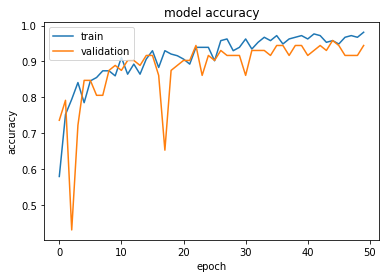

In [53]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

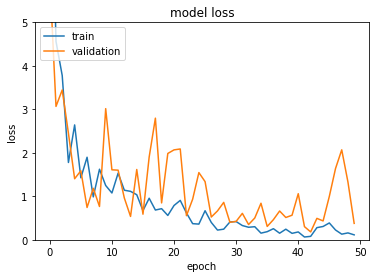

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,5)
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [55]:
# Evaluating model on test data
test_features_vgg = get_bottleneck_features(vgg_model, test_images)
evaluate = model.evaluate(test_features_vgg, test_labels)
print(evaluate) # loss and accuracy

71/71 [==============================] - 0s 274us/step
[1.832077469624264, 0.9014084339141846]



- train accuracy: 0.9813
- validation accuracy: 0.9444 
- test accuracy: 0.9014
